# Empirical A_V Fitter for XShooter Data
## KWD, mid-2019
### MSP Version, 8 November 2019

Goals for the notebook:
1. Estimate Spectral Type and veiling
2. Perform grid comparison with stellar templates of different SpT, veiling, and extinction
3. Infer physical properties: Teff, Lstar, Rstar, Mstar, using tabulated conversions.

Mini steps:
1. Interpolated to save wavelength axis: use rebinspec in spec_modelfit
2. Give reasonable range of Av

#### MSP Notes

1. Install dust_extinction:

  conda config --add channels conda-forge
  
  conda install dust_extinction
  

2. Pull down Manara spectra:

  http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A%2BA/551/A107
  
  (results table -> submit -> individual objects [spU/spV/spN])

In [1]:
# standard imports
import numpy as np
import time
import glob

# astropy imports
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy.stats import SigmaClip

# dust extinction (may need special import)
from dust_extinction.parameter_averages import F99

# custom software
from spec_modelfit import *
from spectools import *

# ipython reload capabilities for edits to external code
#%load_ext autoreload
#%autoreload 2

# plotting helpers
import matplotlib.pyplot as plt
%matplotlib inline

## Spectral Typing in the Visible

In [2]:
# newest xshooter spectrum instead
# data = np.loadtxt('../RV/xshooter_oct_medvis.txt', skiprows=1) # optical Oct data
data = np.loadtxt('../RV/xshooter_dec_medvis.txt', skiprows=1) # optical Dec data


wavelength_object = np.nan_to_num(data[:, 0])/1000.
flux_object = np.nan_to_num(data[:, 1])
uncertainty_object = np.nan_to_num(data[:, 2])

# clean up the values where the uncertainty is zero:
wavelength_object = wavelength_object[uncertainty_object != 0]
flux_object = flux_object[uncertainty_object != 0]
uncertainty_object = uncertainty_object[uncertainty_object != 0]

# set the wavelength bounds
flux_object = flux_object[(wavelength_object > .57) & (wavelength_object < 1.01)]
uncertainty_object = uncertainty_object[(wavelength_object > .57) & (wavelength_object < 1.01)]
wavelength_object = wavelength_object[(wavelength_object > .57) & (wavelength_object < 1.01)]


# convert to a dictionary. as long as this step happens for any other data, we will be able to 
V410vis = {}
V410vis['wave'] = wavelength_object
fl = flux_object*(u.mW)*(u.m**-2)*(u.nm**-1)
V410vis['flux'] = fl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1)).value
V410vis['eflux'] = uncertainty_object




In [3]:
data = np.loadtxt('../RV/xshooter_mednir_dec.txt', skiprows=1) # NIR Dec data

wavelength_object = np.nan_to_num(data[:, 0])/1000.
flux_object = np.nan_to_num(data[:, 1])
uncertainty_object = np.nan_to_num(data[:, 2])

# clean up the values where the uncertainty is zero:
wavelength_object = wavelength_object[uncertainty_object != 0]
flux_object = flux_object[uncertainty_object != 0]
uncertainty_object = uncertainty_object[uncertainty_object != 0]

# set the wavelength bounds
minwave = 1.0
maxwave = 2.45
flux_object = flux_object[(wavelength_object > minwave) & (wavelength_object < maxwave)]
uncertainty_object = uncertainty_object[(wavelength_object > minwave) & (wavelength_object < maxwave)]
wavelength_object = wavelength_object[(wavelength_object > minwave) & (wavelength_object < maxwave)]

# where do we want to blank out for telluric issues?


# convert to a dictionary. as long as this step happens for any other data, we will be able to 
V410nir = {}
V410nir['wave'] = wavelength_object
fl = flux_object*(u.mW)*(u.m**-2)*(u.nm**-1)
V410nir['flux'] = fl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1)).value

V410nir['eflux'] = uncertainty_object





## Load in Manara+ spectra, but from their own reductions (VizieR)

This data has been pulled directly from the Manara paper. Unfortunately, there are no error bars. The best we can assume is 5% error. Perhaps we need to do a Monte Carlo error, but I'm not sure if it will matter.

In [4]:

# read in all templates
# read all of the visible arm spectra into a dictionary:
manara_specV = {}
V_templates = glob.glob('../Extinction/Manara2013_Library/ManaraReductions/*_V.txt')

print(V_templates)

# when bringing in, should bring to the native resolution of the data?
# rebin spec takes a minute or two (what version of this do I have?)

for templ in V_templates:
    print(templ)
    wvtmp, fltmp = np.genfromtxt(templ, skip_header=1, unpack=True)
    
    wvtmp/=1000.
    print(np.nanmin(V410vis['wave']),np.nanmin(wvtmp))
    print(np.nanmax(V410vis['wave']),np.nanmax(wvtmp))


    # do the rebin.
    
    rebin_flux = rebinspec(wvtmp, fltmp, V410vis['wave'])
    #rebin_flux = spectres(V410['wave'], wvtmp,fltmp, spec_errs=None)
    
    fl = rebin_flux*(u.mW)*(u.m**-2)*(u.nm**-1)
    conv_fl = fl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1))
    manara_specV[templ] = {}
    manara_specV[templ]['wave'] = V410vis['wave']
    manara_specV[templ]['flux'] = conv_fl.value


['../Extinction/Manara2013_Library/ManaraReductions/01_Sz121_M4.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/05_Par-Lup3-2_M5.0_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/06_SO925_M5.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/07_SO999_M5.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/09_Par-Lup3-1_M6.5_V.txt', '../Extinction/Manara2013_Library/ManaraReductions/10_TWA26_M7.0_V.txt']
../Extinction/Manara2013_Library/ManaraReductions/01_Sz121_M4.0_V.txt
0.5700042294469999 0.53366
1.00999205611 1.01998
../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_V.txt
0.5700042294469999 0.545
1.00999205611 1.035
../Extinction/Manara2013_Li

## An experiment to find the spectral typing, in visible

In [5]:
# this is a historical test for scalings

#for idx,templ in enumerate(V_templates):
#    offset = compare_spectra(manara_specV[templ],V410vis,plotting=True,title=templ.split('/')[-1],av=0.0)
#    print(templ,offset)


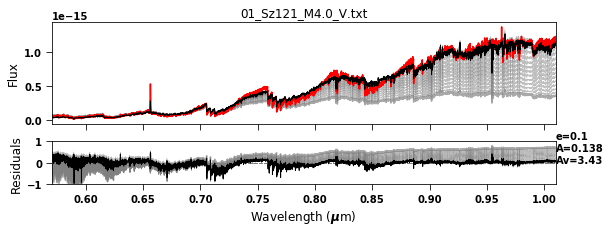

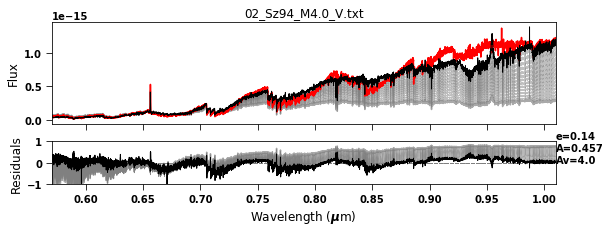

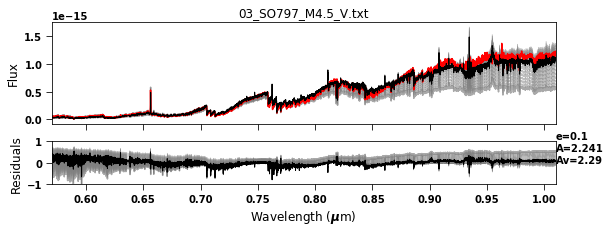

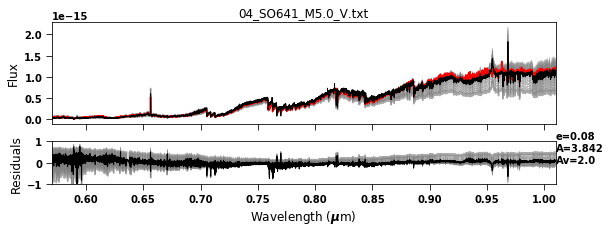

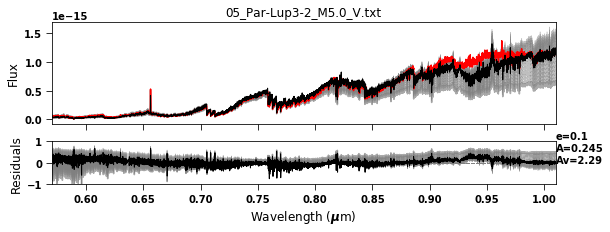

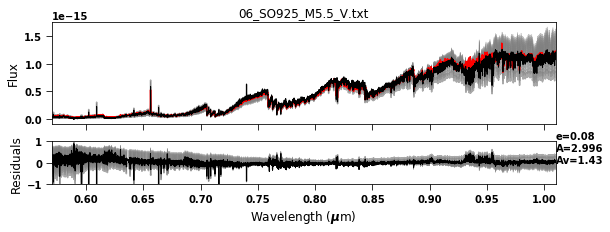

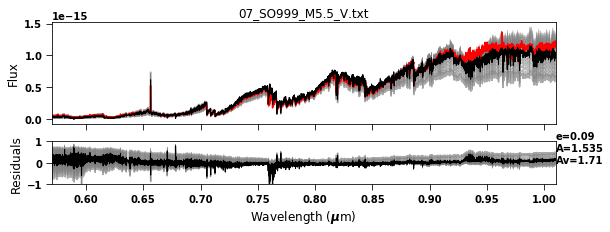

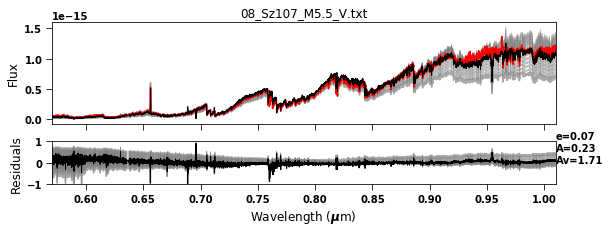

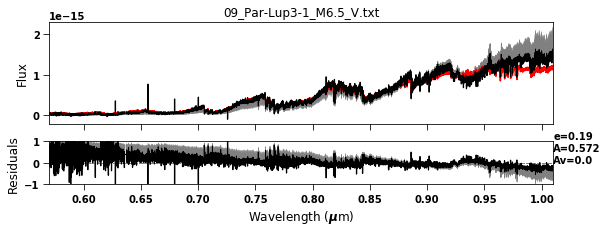

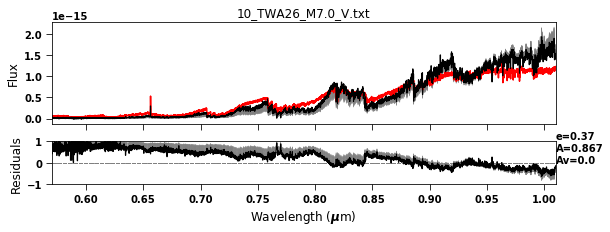

In [6]:

# full extinction fits for visible

for idx,templ in enumerate(V_templates):
    compare_spectra_extinction(manara_specV[templ],V410vis,plotting=True,title=templ.split('/')[-1],extmax=4.,extnum=15)


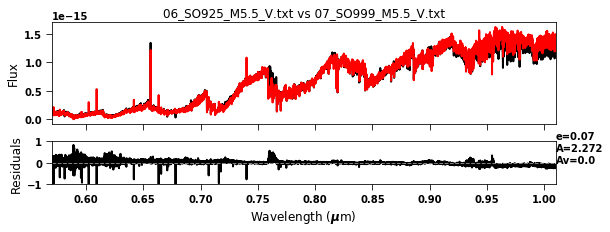

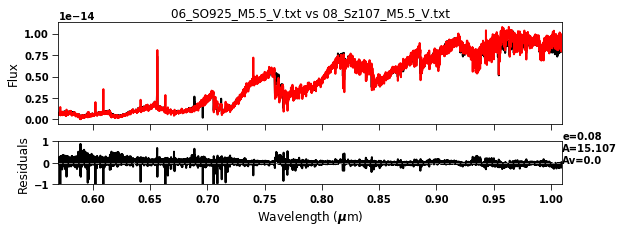

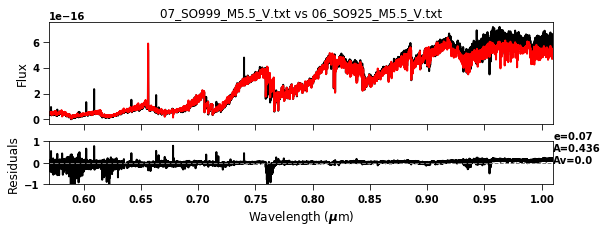

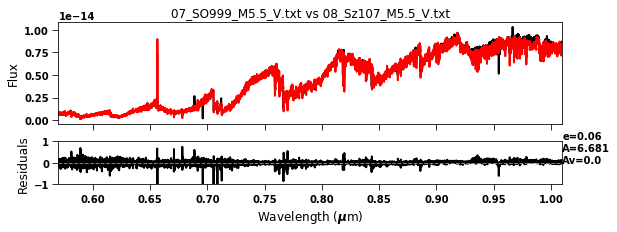

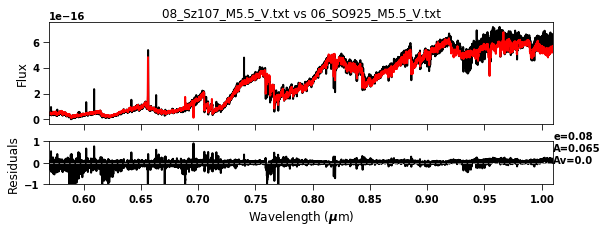

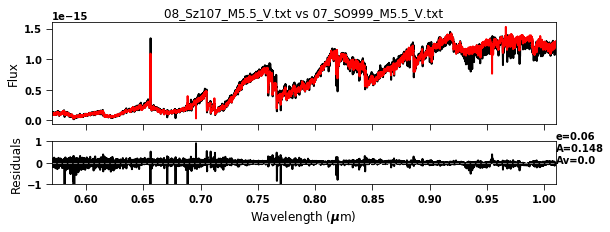

In [7]:
# check the 5.5s against everything else

for idx_in,templ_in in enumerate(V_templates):
    if '5.5' in templ_in:
        for idx,templ in enumerate(V_templates):
            if ('5.5' in templ) & (templ != templ_in):
                offset = compare_spectra(manara_specV[templ],manara_specV[templ_in],plotting=True,title=templ_in.split('/')[-1]+' vs '+templ.split('/')[-1],av=0.)



## NIR Spectral Typing

In [8]:


# read in NIR all templates

# read all of the visible arm spectra into a dictionary:
manara_specN = {}
N_templates = glob.glob('../Extinction/Manara2013_Library/ManaraReductions/*_N.txt')

print(N_templates)

# when bringing in, should bring to the native resolution of the data?
# rebin spec takes a minute or two (what version of this do I have?)

# choose to blank out telluric regions?

for templ in N_templates:
    print(templ)
    wvtmp, fltmp = np.genfromtxt(templ, skip_header=1, unpack=True)
    
    wvtmp/=1000.
    print(np.nanmin(V410nir['wave']),np.nanmin(wvtmp))
    print(np.nanmax(V410nir['wave']),np.nanmax(wvtmp))


    # do the rebin.
    
    rebin_flux = rebinspec(wvtmp, fltmp, V410nir['wave'])
    #rebin_flux = spectres(V410['wave'], wvtmp,fltmp, spec_errs=None)
    
    fl = rebin_flux*(u.mW)*(u.m**-2)*(u.nm**-1)
    conv_fl = fl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1))
    manara_specN[templ] = {}
    manara_specN[templ]['wave'] = V410nir['wave']
    manara_specN[templ]['flux'] = conv_fl.value




['../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/05_Par-Lup3-2_M5.0_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/06_SO925_M5.5_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/07_SO999_M5.5_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_N.txt', '../Extinction/Manara2013_Library/ManaraReductions/09_Par-Lup3-1_M6.5_N.txt']
../Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_N.txt
1.00005233112 0.99402
2.4499722155600003 2.47896
../Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_N.txt
1.00005233112 0.99402
2.4499722155600003 2.47896
../Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_N.txt
1.00005233112 0.9941
2.4499722155600003 2.4789
../Extinction/Manara2013_Library/ManaraReductions/05

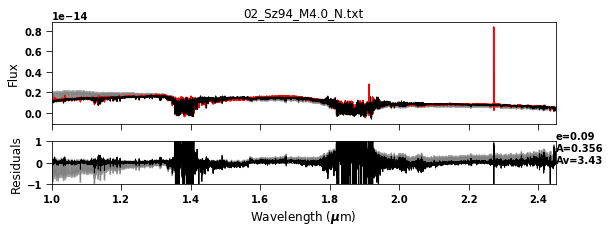

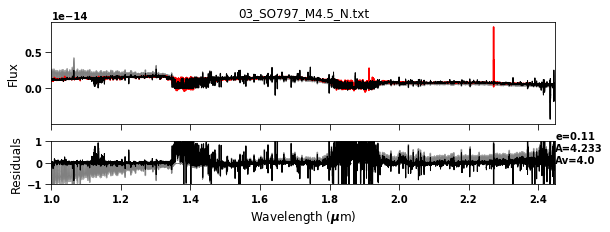

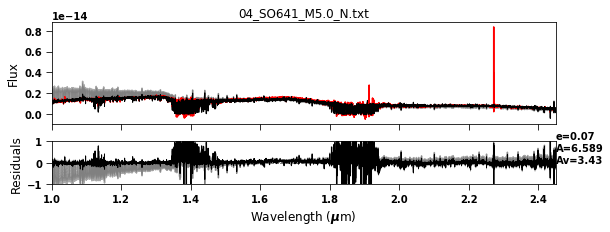

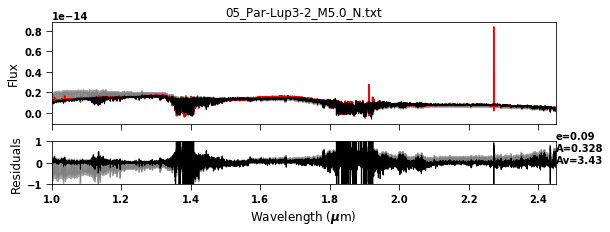

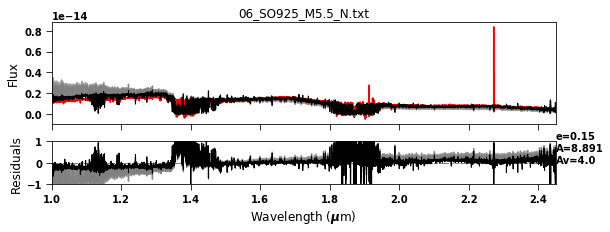

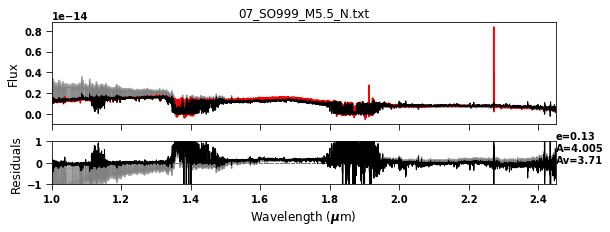

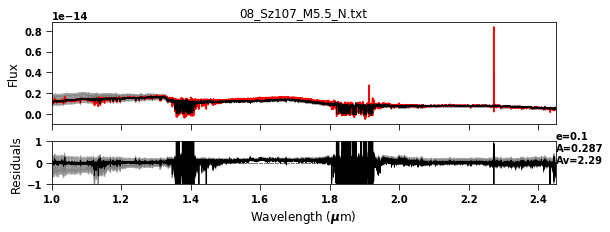

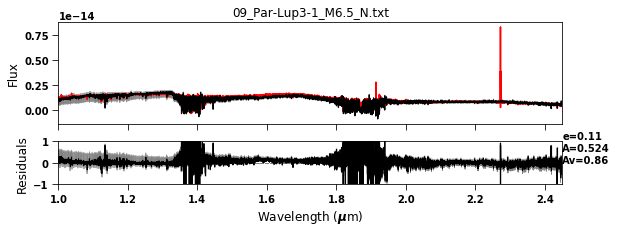

In [9]:

# this is a historical test for scalings

#for idx,templ in enumerate(N_templates):
#    offset = compare_spectra(manara_spec[templ],V410nir,plotting=True,title=templ.split('/')[-1],av=0.0)
#    print(templ,offset)



# full extinction fits for NIR

for idx,templ in enumerate(N_templates):
    compare_spectra_extinction(manara_specN[templ],V410nir,plotting=True,title=templ.split('/')[-1],extmax=4.,extnum=15)




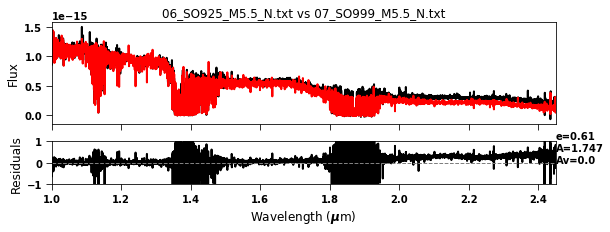

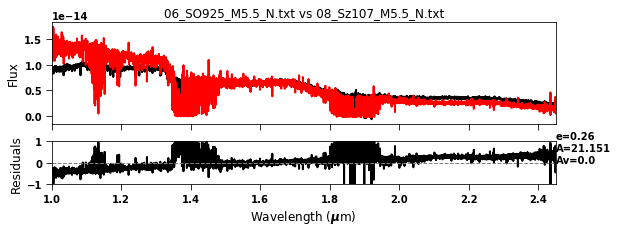

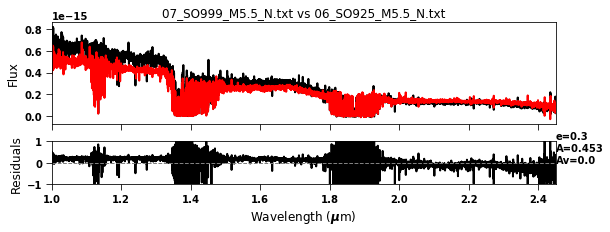

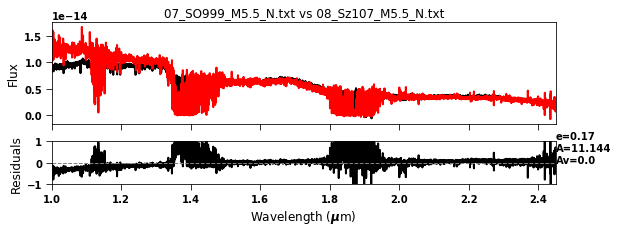

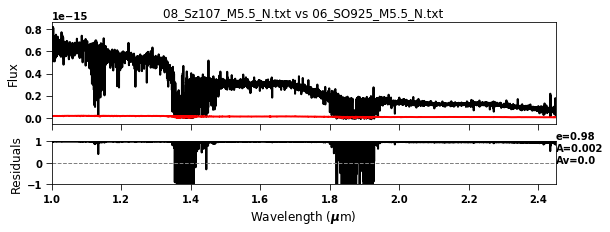

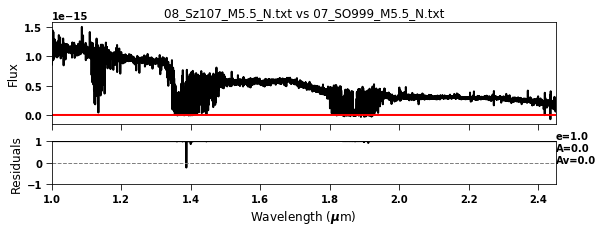

In [10]:
# check the 5.5s against everything else

for idx_in,templ_in in enumerate(N_templates):
    if '5.5' in templ_in:
        for idx,templ in enumerate(N_templates):
            if ('5.5' in templ) & (templ != templ_in):
                offset = compare_spectra(manara_specN[templ],manara_specN[templ_in],plotting=True,title=templ_in.split('/')[-1]+' vs '+templ.split('/')[-1],av=0.)




## Now try scaling for distance:

With the calculated scaling factors in hand, we can attempt to estimate the scaling factors we would expect. As $d{\rm (pc)}=1000{\rm (pc)}/\varpi {\rm (mas)}$

\begin{equation}
\frac{F_1}{F_2} = \frac{d_2^2}{d_1^2} = \frac{\varpi_1^2}{\varpi_2^2}
\end{equation}



In [11]:
# pull distances to the 5.5s from Gaia data (on Simbad)

#SZ107
SZ107 = {}
SZ107['name'] = 'SZ107'
SZ107['parallax']=6.5635
SZ107['eparallax']=0.1095
SZ107['vrad']=6.1
SZ107['evrad']=3.8

#SO999
SO999 = {}
SO999['name'] = 'SO999'
SO999['parallax']=2.8407
SO999['eparallax']=0.1738
SO999['vrad']=np.nan
SO999['evrad']=np.nan

#SO925
SO925 = {}
SO925['name'] = 'SO925'
SO925['parallax']=3.1775
SO925['eparallax']=0.3415
SO925['vrad']=np.nan
SO925['evrad']=np.nan

#Par-Lup3-2
ParLup3 = {}
ParLup3['name'] = 'ParLup3-2'
ParLup3['parallax']=6.0264
ParLup3['eparallax']=0.0945

ParLup3['vrad']=np.nan
ParLup3['evrad']=np.nan

#V410
V410 = {}
V410['name'] = 'V410Xray6'
V410['parallax']=8.3771
V410['eparallax']=0.1532

for obj in (V410,SZ107,SO999,SO925,ParLup3):
    obj['distance'] = 1000./obj['parallax']
    obj['edistance'] = np.abs((1000./(obj['parallax']+obj['eparallax'])) - obj['distance'])


In [12]:
# translated distances and errors

for obj in (V410,SZ107,SO999,SO925,ParLup3):
    print(obj['name'],np.round(obj['distance'],2),'$\pm$',np.round(obj['edistance'],2))

V410Xray6 119.37 $\pm$ 2.14
SZ107 152.36 $\pm$ 2.5
SO999 352.03 $\pm$ 20.3
SO925 314.71 $\pm$ 30.54
ParLup3-2 165.94 $\pm$ 2.56


In [13]:
# comparison to V410 distance and associated error factors

# name, distance, expected scaling, error in expected scaling

for obj in (SZ107,SO999,SO925,ParLup3):
    print(obj['name'],np.round(obj['distance'],2),\
          np.round(obj['distance']**2./V410['distance']**2.,2),\
         np.round(np.sqrt( 4.*( obj['edistance']/ (obj['distance']))**2. +\
                           4.*(V410['edistance']/(V410['distance']))**2.),2))

SZ107 152.36 1.63 0.05
SO999 352.03 8.7 0.12
SO925 314.71 6.95 0.2
ParLup3-2 165.94 1.93 0.05


In [14]:
# test SZ107

print('Compare SZ107 to other standards:')

for obj in (SO999,SO925,ParLup3):
    print(obj['name'],np.round(1000./obj['parallax'],2),\
          np.round(((obj['parallax'])**2.)/(SZ107['parallax']**2.),2))

Compare SZ107 to other standards:
SO999 352.03 0.19
SO925 314.71 0.23
ParLup3-2 165.94 0.84


In [15]:
# test SZ107

print('Compare SO999 to other standards:')

for obj in (SZ107,SO925,ParLup3):
    print(obj['name'],np.round(1000./obj['parallax'],2),\
          np.round(((obj['parallax'])**2.)/(SO999['parallax']**2.),2))

Compare SO999 to other standards:
SZ107 152.36 5.34
SO925 314.71 1.25
ParLup3-2 165.94 4.5
